# Extracting Structural Properties of MOFs

โดย รังสิมันต์ เกษแก้ว <br>
มหาวิทยาลัยแห่งซูริค <br>
E-mail: rangsiman1993@gmail.com

ในบทเรียนนี้เราจะมาทำความเข้าใจ training set และวิธีการคำนวณคุณสมบัติเชิงโครงสร้างของ MOF 
- ความหนาแน่น (Density)
- Gravimetric Surface Area (GSA)
- Volumetric Surface Area (VSA) 

โดยหน่วยของ GSA มักจะรายงานเป็น $m^{2}/g$ นั่นก็คือ พื้นที่ผิว (ตารางเมตร) ต่อ MOF 1 กรัม <br>
และหน่วยของ VSA มักจะรายงานเป็น $m^{2}/cm^{3}$ นั่นก็คือ พื้นที่ผิว (ตารางเมตร) ต่อ MOF 1 ลูกบาศก์เซนติเมตร

## 0. Import everything you need

In [47]:
import os
import sys
import re
import copy
import string
import math
import numpy as np
import pandas as pd
from ase.io import read

from operator import itemgetter
from itertools import groupby

In [48]:
DATA_DIR = '../dataset/'
DATA_FILE = os.path.join(DATA_DIR, 'train.csv')

## 1. Import the data

In [49]:
df = pd.read_csv(DATA_FILE)
df.shape

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/train.csv'

Let's take a look at the first few rows to see if everythings seems reasonable ...

In [ ]:
df.head()

,MOFname,volume [A^3],weight [u],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,organic_linker2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],CO2_working_capacity [mL/g]
0,mof_unit_1,1116.667429,875.240600,0.00,0.07899,0.0607,COOH-OEt,3,4,11,pcu,22.864166,6.786041,105.284502
1,mof_unit_2,2769.503842,2211.697211,603.61,0.13794,0.1040,F-OMe,10,44,57,etb,33.616780,7.147286,101.224774
2,mof_unit_3,1089.818728,773.687960,788.50,0.14874,0.1262,OMe-COOH,2,22,24,pcu,19.263726,6.347967,118.987011
3,mof_unit_4,2205.198301,1304.638720,1441.53,0.21814,0.2220,H-SO3H,9,17,24,sra,25.701377,6.190085,187.626004
4,mof_unit_5,1137.800963,901.736120,0.00,0.07778,0.0591,NHMe-OH,2,1,22,pcu,30.001838,6.478063,79.210001


<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>Use something like <code>pd.options.display.max_columns=100</code> to adjust how many columns are shown. <code>pd.options.display.max_columns=100</code>  would show at maximum 100 columns. </li>
</ul>
</details>

Let's also get some basic information ...

ลองสังเกตุ feature แต่ละตัว
- volume ติดลบได้ไหม ?
- void volume มีค่ามากกว่า volume ได้ไหม ?
- void fraction มากกว่า 1 ได้ไหม ?
- heat adsorption ติดลบได้ไหม ?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68613 entries, 0 to 68612
Data columns (total 14 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   MOFname                                        68613 non-null  object 
 1   volume [A^3]                                   68613 non-null  float64
 2   weight [u]                                     68613 non-null  float64
 3   surface_area [m^2/g]                           68613 non-null  float64
 4   void_fraction                                  68613 non-null  float64
 5   void_volume [cm^3/g]                           68613 non-null  float64
 6   functional_groups                              68290 non-null  object 
 7   metal_linker                                   68613 non-null  int64  
 8   organic_linker1                                68613 non-null  int64  
 9   organic_linker2                                686

Play with some features. E.g. `topology`

<AxesSubplot:>

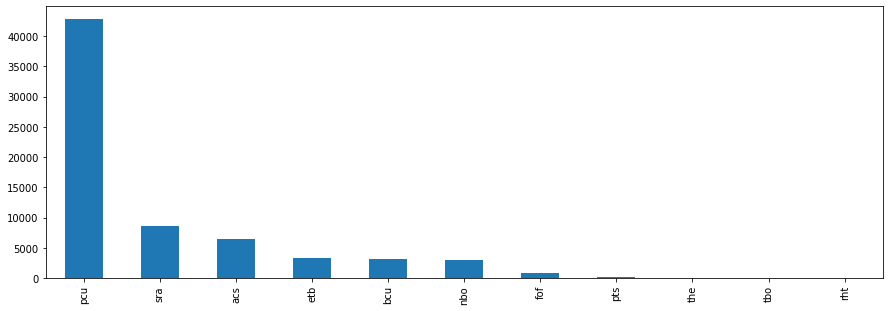

In [ ]:
df.topology.value_counts().plot(figsize=(15,5), kind="bar")

## 2. Density (ความหนาแน่น)

ความหนาแน่น คือ อัตราส่วนมวลต่อปริมาตร (1 Unit Cell)

In [ ]:
df["weight [u]"] / df["volume [A^3]"]  # u / A^3


0        0.783797
1        0.798590
2        0.709924
3        0.591620
4        0.792525
           ...   
68608    0.842967
68609    0.991130
68610    0.962656
68611    0.912996
68612    1.301827
Length: 68613, dtype: float64

เรารู้ว่า 1 Dalton (u) = 1.66054e-24 กรัม

ลองเปลี่ยนหน่วยความหนาแน่นให้เป็น g/cm^3

In [ ]:
(df["weight [u]"] / df["volume [A^3]"]) * 1.66054


0        1.301526
1        1.326090
2        1.178856
3        0.982408
4        1.316020
           ...   
68608    1.399781
68609    1.645811
68610    1.598529
68611    1.516066
68612    2.161736
Length: 68613, dtype: float64

In [ ]:
df.insert(
    loc=3,
    column="density [g/cm^3]",
    value=(df["weight [u]"] / df["volume [A^3]"]) * 1.66054,
)


In [ ]:
df

,MOFname,volume [A^3],weight [u],density [g/cm^3],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,organic_linker2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],CO2_working_capacity [mL/g]
0,mof_unit_1,1116.667429,875.240600,1.301526,0.00,0.07899,0.0607,COOH-OEt,3,4,11,pcu,22.864166,6.786041,105.284502
1,mof_unit_2,2769.503842,2211.697211,1.326090,603.61,0.13794,0.1040,F-OMe,10,44,57,etb,33.616780,7.147286,101.224774
2,mof_unit_3,1089.818728,773.687960,1.178856,788.50,0.14874,0.1262,OMe-COOH,2,22,24,pcu,19.263726,6.347967,118.987011
3,mof_unit_4,2205.198301,1304.638720,0.982408,1441.53,0.21814,0.2220,H-SO3H,9,17,24,sra,25.701377,6.190085,187.626004
4,mof_unit_5,1137.800963,901.736120,1.316020,0.00,0.07778,0.0591,NHMe-OH,2,1,22,pcu,30.001838,6.478063,79.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68608,mof_unit_68609,1188.302573,1001.700216,1.399781,0.00,0.00000,0.0000,Pr-F,3,4,24,pcu,24.131770,NaN,-12.943652
68609,mof_unit_68610,1506.660363,1493.296496,1.645811,0.00,0.01108,0.0000,SO3H,10,42,46,etb,6.071818,NaN,-12.985582
68610,mof_unit_68611,2035.532738,1959.518320,1.598529,0.00,0.00000,0.0000,OPr,4,14,22,acs,9.876134,NaN,-13.187635
68611,mof_unit_68612,3985.426053,3638.677280,1.516066,0.00,0.00000,0.0000,OPr-Me,4,4,15,acs,5.285051,inf,15.672698


## 2. Surface Area (พื้นที่ผิว)

 $\color{DarkBlue}{\textsf{Short question}}$

รถมอเตอร์ไซต์คันนี้มีพื้นที่ผิวเท่าไหร่ ?

![Picture title](motorcycle.png)

พิจารณาระบบดังต่อไปนี้ โดยมีการจำแนกประเภทของพื้นที่ผิวออกเป็น 2 ประเภท
1. van der Waals Surface Area
2. Solvent-accessible Surface Area (SASA)
![Picture title](surface-area.png)

Question: ขนาดของ probe มีผลไหม ?

![Picture title](non-overlap-probes.png)

จากรูปด้านบน มีทรงกลม 3 จาก 5 ลูกที่ไม่ซ้อนทับกับอะตอมในโครงสร้างของ MOF เลย ดังนั้น พื้นที่ผิวของระบบนี้คือ $(\frac{3}{5} * 4πr^{2})$

### 2.1 Define constants (กำหนดค่าคงที่)

In [ ]:
# default global numbers
E = 1e-3
PI = np.pi
angstrom = 1e-10

vdw_radii = {'H': 1.1, 'He': 1.4, 'Li': 1.82, 'Be': 1.53, 'B': 1.92, 'C': 1.7, 'N': 1.55, 
            'O': 1.52, 'F': 1.47, 'Ne': 1.54, 'Na': 2.27, 'Mg': 1.73, 'Al': 1.84, 'Si': 2.1, 
            'P': 1.8, 'S': 1.8, 'Cl': 1.75, 'Ar': 1.88, 'K': 2.75, 'Ca': 2.31, 'Sc': 2.15, 'Ti': 2.11, 
            'V': 2.07, 'Cr': 2.06, 'Mn': 2.05, 'Fe': 2.04, 'Co': 2.0, 'Ni': 1.97, 'Cu': 1.96, 'Zn': 2.01, 
            'Ga': 1.87, 'Ge': 2.11, 'As': 1.85, 'Se': 1.9, 'Br': 1.85, 'Kr': 2.02, 'Rb': 3.03, 'Sr': 2.49, 
            'Y': 2.32, 'Zr': 2.23, 'Nb': 2.18, 'Mo': 2.17, 'Tc': 2.16, 'Ru': 2.13, 'Rh': 2.1, 'Pd': 2.1, 
            'Ag': 2.11, 'Cd': 2.18, 'In': 1.93, 'Sn': 2.17, 'Sb': 2.06, 'Te': 2.06, 'I': 1.98, 'Xe': 2.16, 
            'Cs': 3.43, 'Ba': 2.68, 'La': 2.43, 'Ce': 2.42, 'Pr': 2.4, 'Nd': 2.39, 'Pm': 2.38, 'Sm': 2.36, 
            'Eu': 2.35, 'Gd': 2.34, 'Tb': 2.33, 'Dy': 2.31, 'Ho': 2.3, 'Er': 2.29, 'Tm': 2.27, 'Yb': 2.26, 
            'Lu': 2.24, 'Hf': 2.23, 'Ta': 2.22, 'W': 2.18, 'Re': 2.16, 'Os': 2.16, 'Ir': 2.13, 'Pt': 2.13,
            'Au': 2.14, 'Hg': 2.23, 'Tl': 1.96, 'Pb': 2.02, 'Bi': 2.07, 'Po': 1.97, 'At': 2.02, 'Rn': 2.2, 
            'Fr': 3.48, 'Ra': 2.83, 'Ac': 2.47, 'Th': 2.45, 'Pa': 2.43, 'U': 2.41, 'Np': 2.39, 'Pu': 2.43, 
            'Am': 2.44, 'Cm': 2.45, 'Bk': 2.44, 'Cf': 2.45, 'Es': 2.45, 'Fm': 2.45, 'Md': 2.46, 'No': 2.46, 
            'Lr': 2.46}

### 2.2 Define functions (สร้างฟังก์ชัน)

In [ ]:
def get_box_parameters(cifname):
    """
    ดึงข้อมูลพารามิเตอร์ของ Unit Cell ของ MOF

    cifname : CIF file
    """
    content = open(cifname, 'r').readlines()
    for line in content:
        if "_cell_length_a" in line:
            a = float(line.split()[1])
        if "_cell_length_b" in line:
            b = float(line.split()[1])
        if "_cell_length_c" in line:
            c = float(line.split()[1])
        if "_cell_angle_alpha" in line:
            alpha_r = float(line.split()[1]) * PI / 180.0
        if "_cell_angle_beta" in line:
            beta_r = float(line.split()[1]) * PI / 180.0
        if "_cell_angle_gamma" in line:
            gamma_r = float(line.split()[1]) * PI / 180.0

    return a, b, c, alpha_r, beta_r, gamma_r

In [ ]:
def get_box_matrix(cifname):
    """
    คำนวณ Unit Cell Matrix 

    cifname : CIF file
    """
    a, b, c, alpha_r, beta_r, gamma_r = get_box_parameters(cifname)

    a_x = a
    a_y = 0.0
    a_z = 0.0
    b_x = b * np.cos(gamma_r)
    b_y = b * np.sin(gamma_r)
    b_z = 0.0
    c_x = c * np.cos(beta_r)
    c_y = (b * c * np.cos(alpha_r) - b_x * c_x) / b_y
    c_z = np.sqrt(c**2 - c_x**2 - c_y**2)

    cell_matrix = np.matrix([
        [a_x, a_y, a_z], 
        [b_x, b_y, b_z], 
        [c_x, c_y, c_z]], 
        dtype=float)

    crs = np.cross([b_x, b_y, b_z], [c_x, c_y, c_z])
    inverse_matrix = cell_matrix.I
    unit_cell_volume = a_x * crs[0] + a_y * crs[1] + a_z * crs[2]
    
    return cell_matrix, inverse_matrix, unit_cell_volume

In [ ]:
def get_atomic_coordinates(cifname):
    """
    ดึงข้อมูล atomic symbol และ Cartesian coordinates
    """
    ase_atoms = read(cifname) 
    return ase_atoms.get_chemical_symbols(), ase_atoms.get_positions()

In [ ]:
def RandomNumberOnUnitSphere():
	thetha = 0.0
	phi = 0.0
	theta = 2*PI*np.random.random_sample()
	phi = np.arccos(2*np.random.random_sample()-1.0)
	x = np.cos(theta)*np.sin(phi)
	y = np.sin(theta)*np.sin(phi)
	z = np.cos(phi)
	
	return x,y,z

In [ ]:
def _dot_product(unit_cell_matrix, atom_positions):
    s_x = unit_cell_matrix.item(0) * atom_positions[0] + unit_cell_matrix.item(3) * atom_positions[1] + unit_cell_matrix.item(6) * atom_positions[2]
    s_y = unit_cell_matrix.item(1) * atom_positions[0] + unit_cell_matrix.item(4) * atom_positions[1] + unit_cell_matrix.item(7) * atom_positions[2]
    s_z = unit_cell_matrix.item(2) * atom_positions[0] + unit_cell_matrix.item(5) * atom_positions[1] + unit_cell_matrix.item(8) * atom_positions[2]
    new_coord = np.array([s_x, s_y, s_z], float)
    
    return new_coord

In [ ]:
def ApplyBoundaryConditions(vec2, pos, cell_matrix):
	w = [0,0,0]
	x = [0,0,0]
	vec2 = copy.deepcopy(np.asarray(vec2))
	inverse_matrix2 = copy.deepcopy(np.asarray(inverse_matrix))
	fractional = _dot_product(inverse_matrix, vec2)
	# apply boundary conditions
	x[0] = fractional[0] - np.rint(fractional[0])
	x[1] = fractional[1] - np.rint(fractional[1])
	x[2] = fractional[2] - np.rint(fractional[2])
	cartesian = _dot_product(cell_matrix,x)
	
	return cartesian

In [ ]:
def CheckSurfaceAreaOverlap(pAtom, pos, cell_matrix, atom_type, vdW_pAtom, fAtom_b):
	"""
	ตรวจสอบว่า Probe กับอะตอมซ้อนทับกันไหม
	"""
	well_depth_factor = 1.0
	fAtom_o = [0,0,0]
	distance = [0,0,0]
	# start enumerating all atoms in the object
	for i, elem in enumerate(pos):
		fAtom_o = copy.deepcopy(elem)
		if not np.array_equal(fAtom_o,fAtom_b):
			vdW_fAtom = vdw_radii.get(atom_type[i])
			equilibrium_distance = well_depth_factor * 0.5 * (vdW_pAtom + vdW_fAtom)
			fAtom_o = _dot_product(cell_matrix,fAtom_o)
			distance[0] = pAtom[0] - fAtom_o[0]
			distance[1] = pAtom[1] - fAtom_o[1]
			distance[2] = pAtom[2] - fAtom_o[2]
			dr = ApplyBoundaryConditions(distance, pos, cell_matrix)
			rr = (dr[0] * dr[0]) + (dr[1] * dr[1]) + (dr[2] * dr[2])
			if rr < (equilibrium_distance * equilibrium_distance):
				return True
				
	return False

In [ ]:
def gsa(atom_type, pos, cell_matrix, inverse_matrix, unit_cell_volume, probe_diameter=1.0, nSample=20, equilibrium_distance=0.0, InsertTypeOfAtoms=None):
	
	"""
	Computes geometric surface area (GSA) of atoms. Return GSA in m^2/cm^3.

	atom_type : type of atom
	pos : coordinates
	cell_matrix : Crystall cell matrix (A, B, C)
	inverse_matrix: Inverse of crystall cell matrix
	probe_diameter : Diameter of a probe
	nSample : Number of sample probes
	equilibrium_distance = Equilibrium distance upon probe and atom in structure
	InsertTypeOfAtoms = Type of atom insert
	"""
	total = 0.0
	counted = 0.0
	vec = []
	examined_coordinates = []
	SurfaceAreaAverage = 0.0
	well_depth_factor = 1.0
	
	# start enumerating all atoms in the framework
	for i, elem in enumerate(atom_type):
		total=0.0
		counted=0.0
		if np.linalg.norm([pos[i][0], pos[i][1], pos[i][2]]) not in examined_coordinates:
			# check atomType to see if we want to insert probes around the atom
			if InsertTypeOfAtoms is atom_type[i]:
				vdW_fAtom = vdw_radii.get(elem)
				# Lorentz rule of mixing hard spheres 
				equilibrium_distance = well_depth_factor * (0.5 * (probe_diameter + vdW_fAtom))
				# start MC sampling for a given #
				for attempt in range(nSample):
					pAtom = np.array([0.0, 0.0, 0.0], float)
					total += 1
					# find a random number around the sphere
					vec = RandomNumberOnUnitSphere()
					# calculate the coordinates of the center of probe using vec and equilibrium distance
					pAtom[0] = pos[i][0]+vec[0]*equilibrium_distance
					pAtom[1] = pos[i][1]+vec[1]*equilibrium_distance
					pAtom[2] = pos[i][2]+vec[2]*equilibrium_distance
					# store the x,y,z coordinates of probe in an array
					vec2 = np.array([pAtom[0], pAtom[1], pAtom[2]])
					# check for the overlap between probe and the other framework atoms
					overlap = CheckSurfaceAreaOverlap(pAtom, pos, cell_matrix, atom_type, probe_diameter, pos[i])
					if not overlap:
						counted += 1

				# print("fraction of insertion near", atom_type[i], "is", counted/total)
				tmp = (counted/total)*4.0*PI*(equilibrium_distance * equilibrium_distance)

				SurfaceAreaAverage += tmp
				tmp2 = np.array([pos[i][0], pos[i][1], pos[i][2]])
				examined_coordinates.append(np.linalg.norm(tmp2))

	# print ("Surface Area in Ang^2: ", SurfaceAreaAverage)
	# print ("volume of unit cell: ", unit_cell_volume)
	# print ("Surface Area in m^2/cm^3: ", 1e4*SurfaceAreaAverage/unit_cell_volume)
	
	return 1e4*SurfaceAreaAverage/unit_cell_volume

In [ ]:
def vsa(atom_type, pos, cell_matrix, unit_cell_volume, probe_diameter=1.0, nSample=20, total=0, equilibrium_distance=0.0):
	"""
	Computes the volumetric surface area (VSA) of atoms. Return VSA in m^2/cm3.

	atom_type : type of atom
	pos : coordinates
	cell_matrix : Crystall cell matrix (A, B, C)
	probe_diameter : Diameter of a probe
	nSample : Number of sample probes
	equilibrium_distance = Equilibrium distance upon probe and atom in structure
	"""
	counted = 0.0
	vec = np.zeros((1,3), float)
	SurfaceAreaAverage = 0.0
	well_depth_factor = 1.0
	fractional_list = []

	# start enumerating all atoms in the framework
	for i, elem in enumerate(atom_type):
		total = 0.0
		counted = 0.0
		vdW_fAtom = vdw_radii.get(elem)
		# Lorentz rule of mixing hard spheres 
		equilibrium_distance = well_depth_factor * 0.5 * (probe_diameter + vdW_fAtom)

		# start MC sampling for a given #
		for attempt in range(nSample):
			pAtom = np.array([0.0, 0.0, 0.0], float)
			total += 1
			# find a random number around the sphere
			vec = RandomNumberOnUnitSphere()
			# calculate the coordinates of the center of probe using vec and equilibrium distance
			fAtom_xyz = _dot_product(cell_matrix, pos[i])
			pAtom[0] = fAtom_xyz[0] + vec[0]*equilibrium_distance
			pAtom[1] = fAtom_xyz[1] + vec[1]*equilibrium_distance
			pAtom[2] = fAtom_xyz[2] + vec[2]*equilibrium_distance

			# check for the overlap between probe and the other framework atoms
			overlap = CheckSurfaceAreaOverlap(pAtom, pos, cell_matrix, atom_type, probe_diameter, pos[i])
			if not overlap:
				counted += 1

		tmp = (counted/total)*4.0*PI*(equilibrium_distance * equilibrium_distance)

		SurfaceAreaAverage += tmp
		fractional_list.append([elem[0], counted / total, tmp, 1.0e4*tmp/unit_cell_volume])
		# print(i, " out of ", len(atom_type))

	# fractional_list.sort(key=itemgetter(0))

	# file_out = open('freq.txt', 'w')
	# for index, items in groupby(fractional_list, itemgetter(0)):
	# 	sum_area = 0.0
	# 	for atom in items:
	# 		sum_area += atom[2]
	# 		file_out.write('\t'.join(str(i) for i in atom) + '\n')

	return 1.0e4*SurfaceAreaAverage/unit_cell_volume

### 2.3 Let's try estimating GSA and VSA

In [ ]:
# MOF10
df.iloc[9]

MOFname                                          mof_unit_10
volume [A^3]                                      4275.42142
weight [u]                                          1606.196
density [g/cm^3]                                    0.623834
surface_area [m^2/g]                                 3276.11
void_fraction                                        0.41004
void_volume [cm^3/g]                                  0.6573
functional_groups                                    NHMe-OH
metal_linker                                               3
organic_linker1                                           13
organic_linker2                                           29
topology                                                 pcu
CO2/N2_selectivity                                 10.999299
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]       5.539327
CO2_working_capacity [mL/g]                        59.739057
Name: 9, dtype: object

In [ ]:
cifname = "../dataset/mof_unit_10.cif"

cell_matrix, inverse_matrix, unit_cell_volume = get_box_matrix(cifname)
atom_type, pos = get_atomic_coordinates(cifname)

NameError: name 'read' is not defined

In [ ]:
# GSA
gsa_sum = 0
for i in set(atom_type):
    gsa_ = gsa(atom_type, pos, cell_matrix, inverse_matrix, unit_cell_volume, probe_diameter=3.40, nSample=30, InsertTypeOfAtoms=i)
    gsa_sum += gsa_
gsa_sum
# look at Sample in moticalo it can increase to be more accrate(near3276)

NameError: name 'atom_type' is not defined

In [ ]:
gsa_sum / 0.6238338736301693

0.0

In [ ]:
# VSA
vsa(atom_type, pos, cell_matrix, unit_cell_volume, probe_diameter=3.40, nSample=30)

NameError: name 'atom_type' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93f91aea-7a8c-4ac3-b8e5-25215a6d7270' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>